# Appliance Modes Clustering

This notebook is part of my thesis for the MSc in Computer Science and Engineering at the University of Brescia, Italy.

It contains the code for the identification of the appliances' operation modes.

Author: Luca Cotti (<lucacotti98@gmail.com>)

## Setup

In [ ]:
import random, re
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
from joblib import dump, load

# Google Drive Paths
BASE_PATH='/content/drive/MyDrive/Università/Magistrale/Tesi'
APPLIANCES_PATH=f'{BASE_PATH}/Appliances/Raw_avg_60s'
ACTIVATIONS_PATH=f'{BASE_PATH}/Appliances/Activations'
CONSUMPTIONS_PATH=f'{BASE_PATH}/Plots/Consumptions'
LOSSES_PATH=f'{BASE_PATH}/Plots/Losses'
MODELS_PATH=f'{BASE_PATH}/Models'

# Training parameters
EPOCHS=500
PATIENCE=40
BATCH_SIZE=32
SEQUENCE_LENGTH = 896
LOAD_LATEST_MODEL=True

# Seed everything for determinism
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Pyplot style configuration
plt.rcParams['figure.figsize'] = [5, 4]
plt.rcParams['axes.labelsize'] = "medium"
plt.rcParams['font.size'] = 11
plt.rcParams['savefig.bbox'] = "tight"

# Create output dirs
!mkdir -p consumptions
!mkdir -p losses

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Device Information

In [ ]:
!cat /etc/os-release

PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


In [ ]:
!cat /proc/version

Linux version 6.1.58+ (builder@d2af7d2f4328) (Chromium OS 16.0_pre484197_p20230405-r10 clang version 16.0.0 (/var/tmp/portage/sys-devel/llvm-16.0_pre484197_p20230405-r10/work/llvm-16.0_pre484197_p20230405/clang 2916b99182752b1aece8cc4479d8d6a20b5e02da), LLD 16.0.0) #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.150
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa mmi

In [ ]:
!cat /proc/meminfo

MemTotal:       13290480 kB
MemFree:         8157204 kB
MemAvailable:   12002320 kB
Buffers:          341952 kB
Cached:          3687172 kB
SwapCached:            0 kB
Active:           630892 kB
Inactive:        4175156 kB
Active(anon):       1032 kB
Inactive(anon):   777160 kB
Active(file):     629860 kB
Inactive(file):  3397996 kB
Unevictable:           4 kB
Mlocked:               4 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:             30756 kB
Writeback:             0 kB
AnonPages:        776992 kB
Mapped:           267484 kB
Shmem:              1264 kB
KReclaimable:     116400 kB
Slab:             158268 kB
SReclaimable:     116400 kB
SUnreclaim:        41868 kB
KernelStack:        4720 kB
PageTables:        16572 kB
SecPageTables:         0 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6645240 kB
Committed_AS:    1944832 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       75068 kB
VmallocChunk:    

In [ ]:
!python --version

Python 3.10.12


In [ ]:
tf.version.VERSION

'2.15.0'

In [ ]:
!nvidia-smi

Tue Jan 30 10:09:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Analysis of Raw Data

### Import Appliances

In [ ]:
# Upper thresholds used for the clipping of energy consumption values
THRESHOLDS = {
    "fridge": 300,
    "lamp": 50,
    "microwave": 2200,
    "audio_amplifier": 100,
    "television": 175,
    "washing_machine": 2200,
    "dish_washer": 400,
    "desktop_computer": 100,
    "boiler": 125,
    "ac": 1000
}

In [ ]:
def load_appliances():
    # Will contain the home appliance dataset
    appliances = {}

    for appliance_filename, _ in THRESHOLDS.items():
        print(f"Reading {appliance_filename} ... ", end="")

        appliance_name = appliance_filename.split(".")[0]
        appliance_csv = os.path.join(APPLIANCES_PATH, appliance_filename + ".csv")
        appliance_df = pd.read_csv(appliance_csv)

        # Clipping is not done on the raw consumption data, which is only used for plots in this notebook
        #appliance_df.clip(upper=THRESHOLDS[appliance_name], inplace=True)
        appliance_df.dropna(inplace=True)

        appliances[appliance_name] = appliance_df

        print("OK")

    return appliances

In [ ]:
appliances = load_appliances()

Reading fridge ... OK
Reading lamp ... OK
Reading microwave ... OK
Reading audio_amplifier ... OK
Reading television ... OK
Reading washing_machine ... OK
Reading dish_washer ... OK
Reading desktop_computer ... OK
Reading boiler ... OK
Reading ac ... OK


### Plot Consumptions

In [ ]:
def plot_consumptions(appliance_name):
    plt.plot(appliances[appliance_name], 'o', alpha=0.6)
    plt.axhline(y = THRESHOLDS[appliance_name], color = 'r', linestyle = '-')
    plt.xlabel("Sample")
    plt.xticks(rotation=45)
    plt.ylabel("Power consumption (W)")
    plt.grid(alpha=0.4)
    plt.tight_layout()
    plt.savefig(f'consumptions/{appliance_name}.png')
    plt.show()

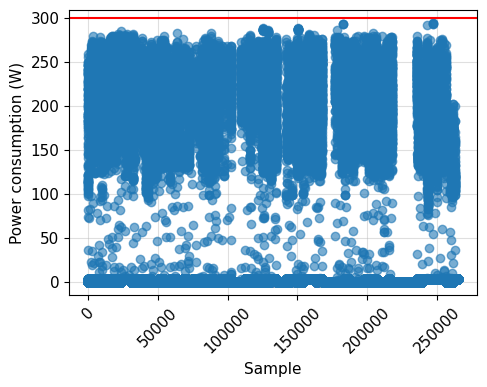

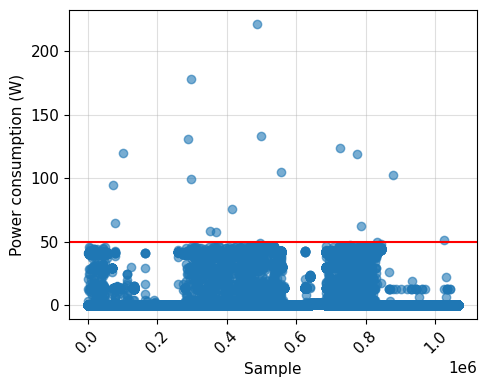

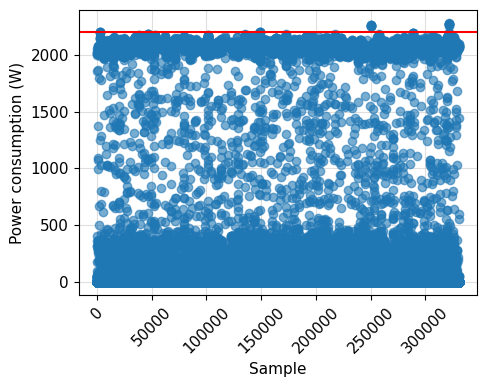

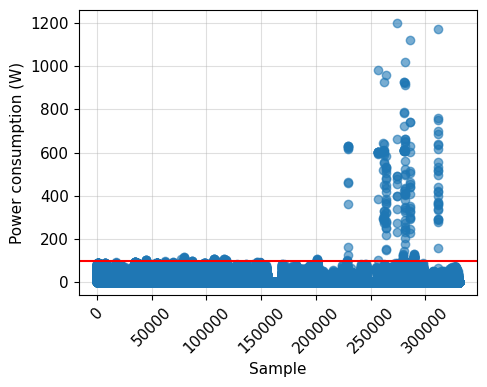

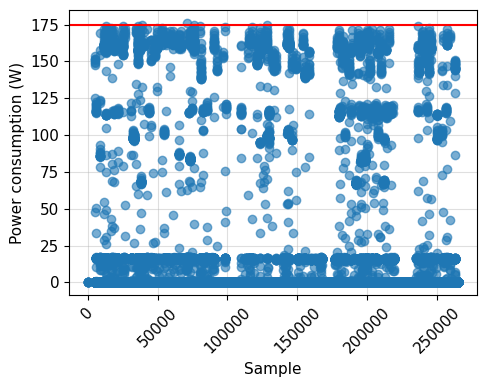

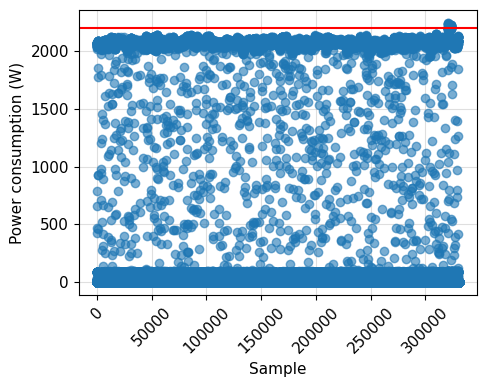

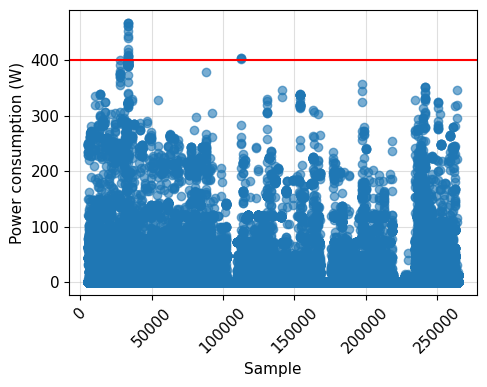

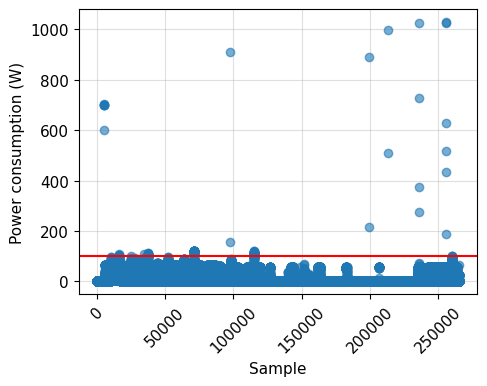

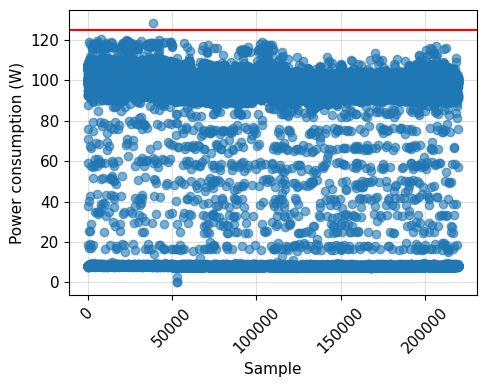

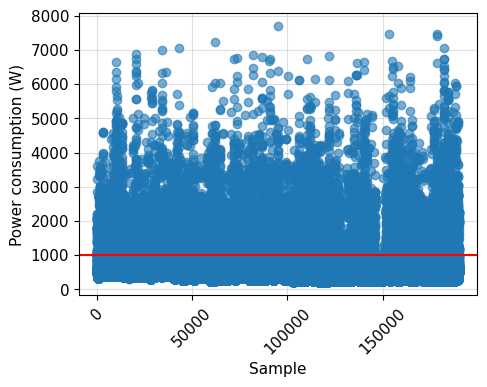

In [ ]:
for appliance, _ in appliances.items():
    plot_consumptions(appliance)

## Modes Clustering

### Import Activations

In [ ]:
def load_activations():
    activations = {}
    durations = {}

    for i, appliance_dir in enumerate(os.listdir(ACTIVATIONS_PATH)):
        print(f"Reading {appliance_dir} ... ", end="")

        appliance_activations = []
        appliance_duration = []

        for j, activation_file in enumerate(os.listdir(os.path.join(ACTIVATIONS_PATH, appliance_dir))):

            activation_csv = os.path.join(ACTIVATIONS_PATH, appliance_dir, activation_file)
            activation_df = pd.read_csv(activation_csv, header=None)

            activation_df.dropna(inplace=True)
            activation_df.clip(upper=THRESHOLDS[appliance_dir], inplace=True)

            appliance_duration.append(activation_df.size)

            if len(activation_df) > SEQUENCE_LENGTH:
                activation_df = activation_df.head(SEQUENCE_LENGTH)
            else:
                len_to_pad = max(0, SEQUENCE_LENGTH - len(activation_df))
                padding = pd.Series([0]*len_to_pad)
                activation_df = pd.concat([activation_df, padding], ignore_index=True)

            appliance_activations.append(activation_df.T)

        activations[appliance_dir] = pd.concat(appliance_activations, ignore_index=True)
        durations[appliance_dir] = np.array(appliance_duration)

        print("OK")

    return activations, durations

In [ ]:
activations, durations = load_activations()

Reading audio_amplifier ... OK
Reading desktop_computer ... OK
Reading washing_machine ... 

<ipython-input-7-227a99989f9f>:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  padding = pd.Series([0]*len_to_pad)
<ipython-input-7-227a99989f9f>:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  padding = pd.Series([0]*len_to_pad)


OK
Reading microwave ... OK
Reading fridge ... OK
Reading dish_washer ... OK
Reading television ... OK
Reading ac ... 

<ipython-input-7-227a99989f9f>:26: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  padding = pd.Series([0]*len_to_pad)


OK
Reading boiler ... OK
Reading lamp ... OK


In [ ]:
for appliance, actvs in activations.items():
    print(appliance, len(actvs))

audio_amplifier 1344
desktop_computer 331
washing_machine 609
microwave 2311
fridge 237
dish_washer 727
television 239
ac 1095
boiler 607
lamp 812


In [ ]:
activations["fridge"]

,0,1,2,3,4,5,6,7,8,9,...,886,887,888,889,890,891,892,893,894,895
0,0.000000,0.000000,66.601420,120.160070,63.387650,63.387650,173.715010,175.85713,130.871350,10.896457,...,177.99924,186.56764,186.56764,188.70972,186.56764,201.56210,207.98820,201.56210,207.98820,207.98820
1,4.468702,2.326105,75.171050,107.306335,47.319386,47.319386,55.889236,175.85713,175.857130,165.146470,...,222.98225,222.98225,222.98225,222.98225,222.98225,222.98225,222.98225,222.98225,222.98225,222.98225
2,4.468702,4.468702,274.388180,274.388180,276.530030,276.530030,197.278000,182.28345,182.283450,182.283450,...,231.55014,250.82756,261.53702,270.10450,259.39514,216.55627,278.67188,278.67188,282.95550,282.95550
3,4.468702,4.468702,111.588930,111.588930,111.588930,111.588930,111.588930,111.58893,111.588930,111.588930,...,252.96947,255.11137,270.10450,274.38818,274.38818,270.10450,237.97601,214.41426,216.55627,222.98225
4,4.468702,4.468702,90.167690,109.448640,55.889236,49.461857,156.577840,175.85713,173.715010,32.321920,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2.326105,4.468702,109.448640,109.448640,47.319386,45.176910,55.889236,81.59821,173.715010,175.857130,...,242.25989,244.40181,244.40181,240.11795,244.40181,235.83406,240.11795,231.55016,233.69211,222.98225
233,0.000000,4.468702,109.448640,49.461857,45.176910,103.021710,175.857130,173.71501,105.164024,4.468702,...,152.29349,143.72470,143.72470,148.00911,150.15129,128.72911,130.87135,133.01360,135.15584,135.15584
234,4.468702,4.468702,88.025330,107.306335,58.031685,49.461857,152.293490,175.85713,36.606937,4.468702,...,169.43076,167.28862,163.00432,160.86217,158.72000,169.43076,171.57288,173.71501,163.00432,158.72000
235,4.468702,4.468702,68.743835,118.017800,49.461857,165.146470,165.146470,180.14134,180.141340,83.740590,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


### K-Means Model

In [ ]:
import scipy
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV

def sil_scorer(estimator, data):
    '''
    Scores the estimator using the silhoutte metric.
    '''
    labels = estimator.fit_predict(data)
    num_clusters = len(np.unique(labels))

    # The number of clusters found should always be > 1 and < number of samples
    if num_clusters == 1 or num_clusters == len(data):
        return -1
    else:
        return silhouette_score(data, labels)

def find_best_kmeans_model(data, min_n_clusters=2, max_n_clusters=4):
    hyperparams = {
        "n_clusters": range(min_n_clusters,max_n_clusters+1) # Integers from 2 to 4
    }

    km = KMeans(n_init="auto")
    rand_search = GridSearchCV(km, hyperparams, scoring=sil_scorer)

    search_result = rand_search.fit(data)
    return search_result.best_estimator_

def get_kmeans_model(n_clusters):
    return KMeans(n_init="auto", n_clusters=n_clusters)

### Autoencoder Model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_encoder(input_shape):
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')

    x = encoder_input

    for _ in range(6):
        x = layers.Conv1D(32, 3, activation='relu', padding='same')(x)
        x = layers.MaxPooling1D()(x)

    x = layers.Bidirectional(layers.LSTM(128, activation='tanh', return_sequences=True))(x)
    x = layers.LSTM(128, activation='tanh', return_sequences=False)(x)

    encoder_output = x

    return models.Model(encoder_input, encoder_output, name='encoder')

def build_decoder(sequence_length):
    decoder_input = layers.Input(shape=(128), name='decoder_input')

    x = layers.RepeatVector(sequence_length//(2**6))(decoder_input)

    x = layers.LSTM(128, activation='tanh', return_sequences=True)(x)

    for _ in range(6):
        x = layers.UpSampling1D()(x)
        x = layers.Conv1D(32, 3, activation='relu', padding='same')(x)

    decoder_output = layers.TimeDistributed(layers.Dense(1))(x)

    return models.Model(decoder_input, decoder_output, name='decoder')

def build_autoencoder(input_shape):
    encoder = build_encoder(input_shape)
    decoder = build_decoder(input_shape[0])

    autoencoder_input = layers.Input(shape=input_shape, name='autoencoder_input')
    encoded_output = encoder(autoencoder_input)
    decoded_output = decoder(encoded_output)

    autoencoder = models.Model(autoencoder_input, decoded_output, name='autoencoder')
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder, encoder, decoder

def get_autoencoder(sequence_length):
    model = build_autoencoder((sequence_length, 1))
    print(model[0].summary())
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

def train(model, X):
    early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

    x_train, x_val, y_train, y_val = train_test_split(X, X, test_size=0.2, random_state=SEED)
    history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, validation_data=(x_val, y_val), callbacks=[early_stopping])

    return history

def plot_history(history, name):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(loss, label='Training loss')
    plt.plot(val_loss, label='Validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.tight_layout()
    plt.legend()
    plt.savefig(f"losses/{name}.pdf")
    plt.show()

In [ ]:
X = pd.DataFrame()

for _, app_acts in activations.items():
    X = pd.concat([X, app_acts], axis=0)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

autoencoder, encoder, decoder = get_autoencoder(SEQUENCE_LENGTH)

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 autoencoder_input (InputLa  [(None, 896, 1)]          0         
 yer)                                                            
                                                                 
 encoder (Functional)        (None, 128)               377632    
                                                                 
 decoder (Functional)        (None, 896, 1)            159457    
                                                                 
Total params: 537089 (2.05 MB)
Trainable params: 537089 (2.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
import glob

if LOAD_LATEST_MODEL:
    list_of_files = glob.glob(MODELS_PATH+ '/*')
    latest_file = max(list_of_files, key=os.path.getctime)
    autoencoder.load_weights(latest_file+"/weights")
    print("Loaded ", latest_file)
else:
    history = train(autoencoder, X_scaled)
    plot_history(history, "full")

Loaded  /content/drive/MyDrive/Università/Magistrale/Tesi/Models/2024_01_07_15_28


In [ ]:
from sklearn.neighbors import NearestCentroid

modes_consumptions = {}
modes_durations = {}

for appliance, app_activations in activations.items():
    # Compute latent state of the activations of the appliance
    X_app = app_activations.copy()
    X_app_scaled = scaler.transform(X_app)
    latent_state = encoder.predict(X_app_scaled)

    # Cluster the latent state
    max_n_clusters= MAX_N_CLUSTERS[appliance] if appliance in MAX_N_CLUSTERS else 4
    km = find_best_kmeans_model(latent_state, max_n_clusters=max_n_clusters)
    labels = km.fit_predict(latent_state)

    # Compute activations corresponding the centers of each cluster
    #centers = decoder.predict(km.cluster_centers_)
    #centers = pd.DataFrame(centers.reshape(len(centers), SEQUENCE_LENGTH))
    #centers = scaler.inverse_transform(centers)
    #centers[centers <= 3] = 0

    # Assign consumptions
    #modes_consumptions[appliance] = centers.mean(axis=1)

    # Compute duration of each centroid
    nrc = NearestCentroid()
    nrc.fit(durations[appliance].reshape(-1,1), labels)

    # Assign durations
    modes_durations[appliance] = np.concatenate(nrc.centroids_).ravel()

    nrc.fit(X_app, labels)
    centers = nrc.centroids_
    modes_consumptions[appliance] = centers.mean(axis=1)

26/26 [==============================] - 1s 30ms/step


### Modes consumptions

In [ ]:
for appliance, consumptions in modes_consumptions.items():
    print(appliance, ": ", np.round(consumptions).astype(int), np.round(modes_durations[appliance]).astype(int))

audio_amplifier :  [ 1 37] [  80 4435]
desktop_computer :  [ 4 41] [ 1159 12142]
washing_machine :  [1783  118 1281   82] [1511 1486 1309 1176]
microwave :  [  42 1265] [ 302 1433]
fridge :  [208   7] [6304   37]
dish_washer :  [136  12  54  41] [2359  240 3025  459]
television :  [110  18] [1833 2514]
ac :  [364  71 671] [ 3754   199 31680]
boiler :  [101  33  57] [2187  300  525]
lamp :  [ 2 19] [309 488]


## Save Results

In [ ]:
from datetime import datetime

today = datetime.now()

today_dir = today.strftime('%Y_%m_%d_%H_%M')
today_consumptions_dir = os.path.join(CONSUMPTIONS_PATH, today_dir)
today_losses_dir = os.path.join(LOSSES_PATH, today_dir)
today_models_dir = os.path.join(MODELS_PATH, today_dir)

In [ ]:
shutil.copytree("consumptions", today_consumptions_dir)

'/content/drive/MyDrive/Università/Magistrale/Tesi/Plots/Consumptions/2024_02_29_13_01'

In [ ]:
shutil.copytree("losses", today_losses_dir)

'/content/drive/MyDrive/Università/Magistrale/Tesi/Plots/Losses/2024_01_07_15_28'

In [ ]:
os.mkdir(today_models_dir)
autoencoder.save_weights(today_models_dir + "/weights")